## About Dataset
#### Context
###### Typically e-commerce datasets are proprietary and consequently hard to find among publicly available data. However, The UCI Machine Learning Repository has made this dataset containing actual transactions from 2010 and 2011. The dataset is maintained on their site, where it can be found by the title "Online Retail".
#### Content
###### "This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers".
#### Acknowledgements
###### Per the UCI Machine Learning Repository, this data was made available by Dr Daqing Chen, Director: Public Analytics group. chend '@' lsbu.ac.uk, School of Engineering, London South Bank University, London SE1 0AA, UK.
#### Inspiration
###### Analyses for this dataset could include time series, clustering, classification and more.
#### data.csv:
###### InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation. 
###### StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product. 
###### Description: Product (item) name. 
###### Nominal.Quantity: The quantities of each product (item) per transaction. Numeric.
###### InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.
###### UnitPrice: Unit price. Numeric, Product price per unit in sterling.
###### CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
###### Country: Country name. Nominal, the name of the country where each customer resides.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import timedelta

from scipy import stats

import warnings
warnings.filterwarnings('ignore')

plt.style.use('dark_background')

%matplotlib inline

#### Loading data

In [3]:
data=pd.read_csv(r'D:\vscode_files\python\notebooks\pet_project\online_retail\data.csv', sep=',', encoding = 'unicode_escape')
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [5]:
data=data.dropna()
data.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

#### What day of the week is the product most often sold?

In [6]:
uniq_id=data.groupby('CustomerID', as_index=False) \
            .agg({'Country':'count'}) \
            .query('Country>10').shape[0]
uniq_id

3707

In [7]:
data['InvoiceDate']=pd.to_datetime(data['InvoiceDate'])

In [8]:
data['day_of_the_week']=data['InvoiceDate'].dt.day_name()
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,day_of_the_week
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,Wednesday
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,Wednesday
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,Wednesday
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,Wednesday
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,Wednesday


In [9]:
days=data.groupby('day_of_the_week', as_index=False).agg({'Country':'count'})
days.head()

,day_of_the_week,Country
0,Friday,56127
1,Monday,66382
2,Sunday,63237
3,Thursday,82374
4,Tuesday,68110


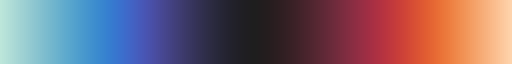

In [10]:
sns.color_palette("icefire", as_cmap=True)

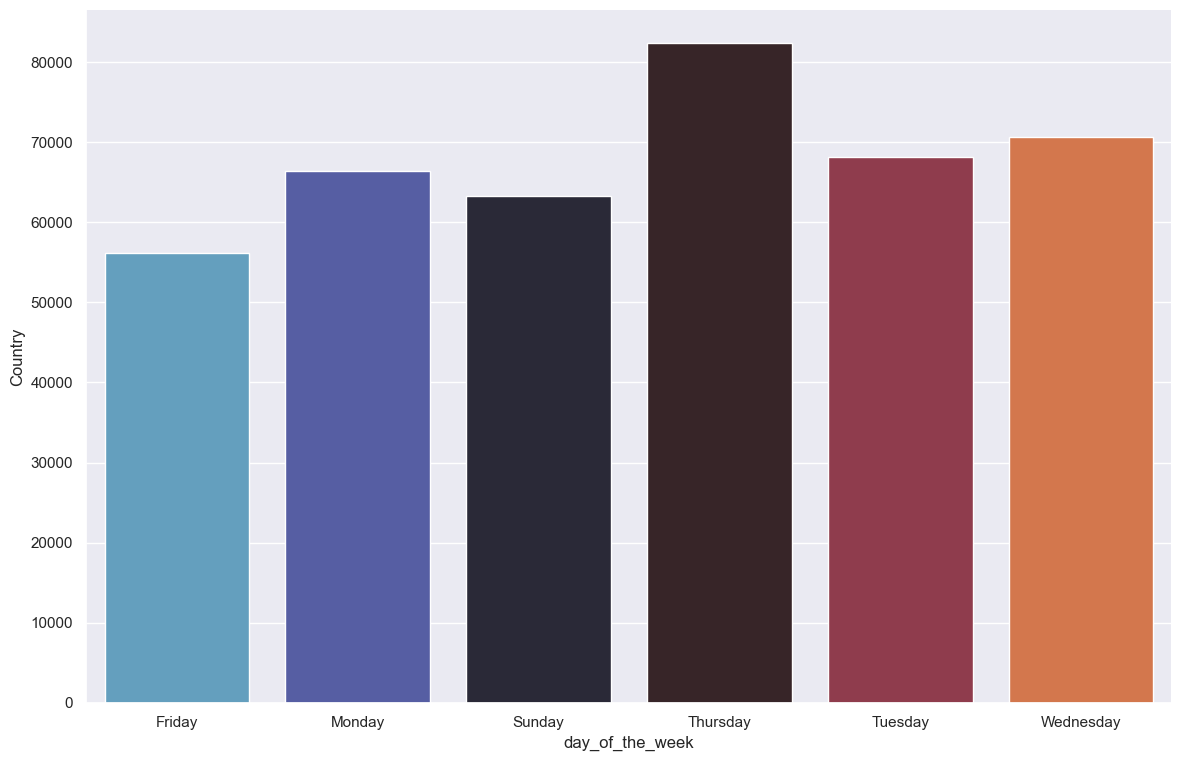

In [11]:
sns.set(rc={'figure.figsize':(14,9)})
sns.barplot(data=days, x='day_of_the_week', y='Country', palette='icefire')
sns.despine()

In [12]:
most_popular_day = data.groupby(['StockCode', 'day_of_the_week']) \
                       .agg({'UnitPrice': 'count'}) \
                       .reset_index()
most_popular_day

,StockCode,day_of_the_week,UnitPrice
0,10002,Friday,9
1,10002,Monday,7
2,10002,Sunday,9
3,10002,Thursday,12
4,10002,Tuesday,7
...,...,...,...
19244,POST,Monday,184
19245,POST,Sunday,85
19246,POST,Thursday,266
19247,POST,Tuesday,191


In [13]:
most_popular_day.pivot(index='StockCode', columns='day_of_the_week', values='UnitPrice') \
                .idxmax(axis=1) \
                .reset_index() \
                .rename(columns={0:'most_popular_day'})

,StockCode,most_popular_day
0,10002,Thursday
1,10080,Monday
2,10120,Friday
3,10123C,Friday
4,10124A,Sunday
...,...,...
3679,D,Thursday
3680,DOT,Monday
3681,M,Monday
3682,PADS,Sunday


#### How many purchases each user has on average per week (by months)?

In [14]:
avg_buys_orders=data.groupby(['InvoiceDate', 'CustomerID'], as_index=False) \
                    .agg({'Country':'count'}) \
                    .rename(columns={'Country':'orders_by_month'})
avg_buys_orders.head()

,InvoiceDate,CustomerID,orders_by_month
0,2010-12-01 08:26:00,17850.0,7
1,2010-12-01 08:28:00,17850.0,2
2,2010-12-01 08:34:00,13047.0,16
3,2010-12-01 08:35:00,13047.0,1
4,2010-12-01 08:45:00,12583.0,20


In [15]:
avg_buys_orders['CustomerID']=avg_buys_orders.CustomerID.apply(lambda x: int(x))
avg_buys_orders.head()

,InvoiceDate,CustomerID,orders_by_month
0,2010-12-01 08:26:00,17850,7
1,2010-12-01 08:28:00,17850,2
2,2010-12-01 08:34:00,13047,16
3,2010-12-01 08:35:00,13047,1
4,2010-12-01 08:45:00,12583,20


In [16]:
avg_buys_orders['weeks'] = (avg_buys_orders['InvoiceDate'].dt.daysinmonth) / 7
avg_buys_orders.head(5)

,InvoiceDate,CustomerID,orders_by_month,weeks
0,2010-12-01 08:26:00,17850,7,4.428571
1,2010-12-01 08:28:00,17850,2,4.428571
2,2010-12-01 08:34:00,13047,16,4.428571
3,2010-12-01 08:35:00,13047,1,4.428571
4,2010-12-01 08:45:00,12583,20,4.428571


In [17]:
avg_buys_orders['orders_by_week']=avg_buys_orders['orders_by_month']/avg_buys_orders['weeks']
avg_buys_orders.head()

,InvoiceDate,CustomerID,orders_by_month,weeks,orders_by_week
0,2010-12-01 08:26:00,17850,7,4.428571,1.580645
1,2010-12-01 08:28:00,17850,2,4.428571,0.451613
2,2010-12-01 08:34:00,13047,16,4.428571,3.612903
3,2010-12-01 08:35:00,13047,1,4.428571,0.225806
4,2010-12-01 08:45:00,12583,20,4.428571,4.516129


#### Let's write a python function that allows us to build a cohort analysis. In the period from January to December, we will try to identify the cohort with the highest retention for the 3rd month.
###### To begin with, let's take the initial data on customers and orders and form a new dataframe for the task from them. Then we add a column with the date of the order in the format ``Year-Month'`.

In [18]:
cohorts = data[['CustomerID', 'InvoiceDate']]

In [19]:
cohorts['CustomerID']=data.CustomerID.apply(lambda x: int(x))
cohorts['order_month']=data.InvoiceDate.apply(lambda x: x.strftime('%Y-%m'))
cohorts.head()

,CustomerID,InvoiceDate,order_month
0,17850,2010-12-01 08:26:00,2010-12
1,17850,2010-12-01 08:26:00,2010-12
2,17850,2010-12-01 08:26:00,2010-12
3,17850,2010-12-01 08:26:00,2010-12
4,17850,2010-12-01 08:26:00,2010-12


In [20]:
cohorts.set_index('CustomerID', inplace=True)
cohorts['join_month']=cohorts.groupby(level=0)['InvoiceDate'].min().apply(lambda x: x.strftime('%Y-%m'))
cohorts.reset_index(inplace=True)
cohorts.insert(len(cohorts.columns), 'orders_num', 0, allow_duplicates=False)
cohorts.head()

,CustomerID,InvoiceDate,order_month,join_month,orders_num
0,17850,2010-12-01 08:26:00,2010-12,2010-12,0
1,17850,2010-12-01 08:26:00,2010-12,2010-12,0
2,17850,2010-12-01 08:26:00,2010-12,2010-12,0
3,17850,2010-12-01 08:26:00,2010-12,2010-12,0
4,17850,2010-12-01 08:26:00,2010-12,2010-12,0


In [21]:
cohorts_1=cohorts.groupby(['join_month', 'order_month']) \
                 .agg({'CustomerID':'nunique', 'orders_num':'count'}) \
                 .rename(columns={'CustomerID':'total_customers'})
cohorts_1.head()

total_customers  orders_num
join_month order_month                             
2010-12    2010-12                  948       26850
           2011-01                  362       10881
           2011-02                  317        9183
           2011-03                  367       12111
           2011-04                  341       10092

In [22]:
def CohortPeriod(C):
    C['cohort_period']=np.arange(len(C))
    return C
cohorts_1 = cohorts_1.groupby(level=0).apply(CohortPeriod).reset_index(level=0, drop=True)
cohorts_1.head()

total_customers  orders_num  cohort_period
join_month order_month                                            
2010-12    2010-12                  948       26850              0
           2011-01                  362       10881              1
           2011-02                  317        9183              2
           2011-03                  367       12111              3
           2011-04                  341       10092              4

In [23]:
cohorts_1.reset_index(inplace=True)
cohorts_1.set_index(['cohort_period', 'join_month'], inplace=True)
cohorts_1.head()

,,order_month,total_customers,orders_num
cohort_period,join_month,,,
0,2010-12,2010-12,948,26850
1,2010-12,2011-01,362,10881
2,2010-12,2011-02,317,9183
3,2010-12,2011-03,367,12111
4,2010-12,2011-04,341,10092


In [24]:
cohort_group_size=cohorts_1['total_customers'].groupby(level=1).first()
cohorts_1['total_customers'].unstack(0)

cohort_period,0,1,2,3,4,5,6,7,8,9,10,11,12
join_month,,,,,,,,,,,,,
2010-12,948.0,362.0,317.0,367.0,341.0,376.0,360.0,336.0,336.0,374.0,354.0,474.0,260.0
2011-01,421.0,101.0,119.0,102.0,138.0,126.0,110.0,108.0,131.0,146.0,155.0,63.0,NaN
2011-02,380.0,94.0,73.0,106.0,102.0,94.0,97.0,107.0,98.0,119.0,35.0,NaN,NaN
2011-03,440.0,84.0,112.0,96.0,102.0,78.0,116.0,105.0,127.0,39.0,NaN,NaN,NaN
2011-04,299.0,68.0,66.0,63.0,62.0,71.0,69.0,78.0,25.0,NaN,NaN,NaN,NaN
2011-05,279.0,66.0,48.0,48.0,60.0,68.0,74.0,29.0,NaN,NaN,NaN,NaN,NaN
2011-06,235.0,49.0,44.0,64.0,58.0,79.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,191.0,40.0,39.0,44.0,52.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,167.0,42.0,42.0,42.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
retention_rate=cohorts_1['total_customers'].unstack(0).divide(cohort_group_size, axis=0)
retention_rate

cohort_period,0,1,2,3,4,5,6,7,8,9,10,11,12
join_month,,,,,,,,,,,,,
2010-12,1.0,0.381857,0.334388,0.387131,0.359705,0.396624,0.379747,0.354430,0.354430,0.394515,0.373418,0.500000,0.274262
2011-01,1.0,0.239905,0.282660,0.242280,0.327791,0.299287,0.261283,0.256532,0.311164,0.346793,0.368171,0.149644,NaN
2011-02,1.0,0.247368,0.192105,0.278947,0.268421,0.247368,0.255263,0.281579,0.257895,0.313158,0.092105,NaN,NaN
2011-03,1.0,0.190909,0.254545,0.218182,0.231818,0.177273,0.263636,0.238636,0.288636,0.088636,NaN,NaN,NaN
2011-04,1.0,0.227425,0.220736,0.210702,0.207358,0.237458,0.230769,0.260870,0.083612,NaN,NaN,NaN,NaN
2011-05,1.0,0.236559,0.172043,0.172043,0.215054,0.243728,0.265233,0.103943,NaN,NaN,NaN,NaN,NaN
2011-06,1.0,0.208511,0.187234,0.272340,0.246809,0.336170,0.102128,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,1.0,0.209424,0.204188,0.230366,0.272251,0.115183,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,1.0,0.251497,0.251497,0.251497,0.137725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
cohort_analysis= (retention_rate
                 .style
                 .set_caption('User retention by cohort')
                 .highlight_null('black')
                 .format("{:.2%}", na_rep=""))
cohort_analysis

cohort_period,0,1,2,3,4,5,6,7,8,9,10,11,12
join_month,,,,,,,,,,,,,
2010-12,100.00%,38.19%,33.44%,38.71%,35.97%,39.66%,37.97%,35.44%,35.44%,39.45%,37.34%,50.00%,27.43%
2011-01,100.00%,23.99%,28.27%,24.23%,32.78%,29.93%,26.13%,25.65%,31.12%,34.68%,36.82%,14.96%,
2011-02,100.00%,24.74%,19.21%,27.89%,26.84%,24.74%,25.53%,28.16%,25.79%,31.32%,9.21%,,
2011-03,100.00%,19.09%,25.45%,21.82%,23.18%,17.73%,26.36%,23.86%,28.86%,8.86%,,,
2011-04,100.00%,22.74%,22.07%,21.07%,20.74%,23.75%,23.08%,26.09%,8.36%,,,,
2011-05,100.00%,23.66%,17.20%,17.20%,21.51%,24.37%,26.52%,10.39%,,,,,
2011-06,100.00%,20.85%,18.72%,27.23%,24.68%,33.62%,10.21%,,,,,,
2011-07,100.00%,20.94%,20.42%,23.04%,27.23%,11.52%,,,,,,,
2011-08,100.00%,25.15%,25.15%,25.15%,13.77%,,,,,,,,


In [27]:
def C_A(cohorts, customer_unique_id, order_purchase_timestamp):

    cohorts['order_month'] = cohorts[order_purchase_timestamp].apply(lambda x: x.strftime('%Y-%m'))
    
    cohorts.set_index(customer_unique_id, inplace=True)
    
    cohorts['join_month'] = cohorts.groupby(level=0)[order_purchase_timestamp].min().apply(lambda x: x.strftime('%Y-%m'))
    cohorts.reset_index(inplace=True)
    cohorts.insert(len(cohorts.columns), 'orders_num', 0, allow_duplicates=False)

    cohorts_1 = cohorts.groupby(['join_month', 'order_month']) \
                         .agg({customer_unique_id: pd.Series.nunique, 'orders_num': pd.Series.count}) \
                         .rename(columns={customer_unique_id: 'total_customers'})
    def CohortPeriod(Coh):
        Coh['cohort_period'] = np.arange(len(Coh)) + 0
        return Coh
    cohorts_1 = cohorts_1.groupby(level=0).apply(CohortPeriod).reset_index(level=0, drop=True)
    cohorts_1.reset_index(inplace=True)
    cohorts_1.set_index(['cohort_period', 'join_month'], inplace=True)
    cohort_group_size = cohorts_1['total_customers'].groupby(level=1).first()
    retention_rate = cohorts_1['total_customers'].unstack(0).divide(cohort_group_size, axis=0)
    
    return retention_rate 
## rate = C_A(cohorts, 'CustomerID', 'InvoiceDate')
## rate

#### Let's build RFM clusters for users. We derive for each cluster the average values of the metrics R, F, M.

In [28]:
date_max = max(data.InvoiceDate) + timedelta(days=1)

In [29]:
recency = data.groupby('CustomerID') \
              .agg({'InvoiceDate': lambda x: (date_max-x.max()).days}) \
              .reset_index() \
              .rename(columns={'InvoiceDate':'recency'})
recency['recency'] = recency['recency'].astype('int16')

In [30]:
frequency = data.groupby('CustomerID', as_index=False) \
                .agg({'InvoiceDate': 'count'}) \
                .rename(columns={'InvoiceDate': 'frequency'})

In [31]:
monetary = data.groupby('CustomerID', as_index=False) \
                      .agg({'UnitPrice': 'sum'}) \
                      .rename(columns={'UnitPrice': 'monetary'})

In [32]:
rfm = recency.merge(frequency, on='CustomerID').merge(monetary) \
             .rename(columns={'order_purchase_timestamp_x': 'recency', 'order_purchase_timestamp_y': 'frequency'})
rfm.head()

,CustomerID,recency,frequency,monetary
0,12346.0,326,2,2.08
1,12347.0,2,182,481.21
2,12348.0,75,31,178.71
3,12349.0,19,73,605.10
4,12350.0,310,17,65.30


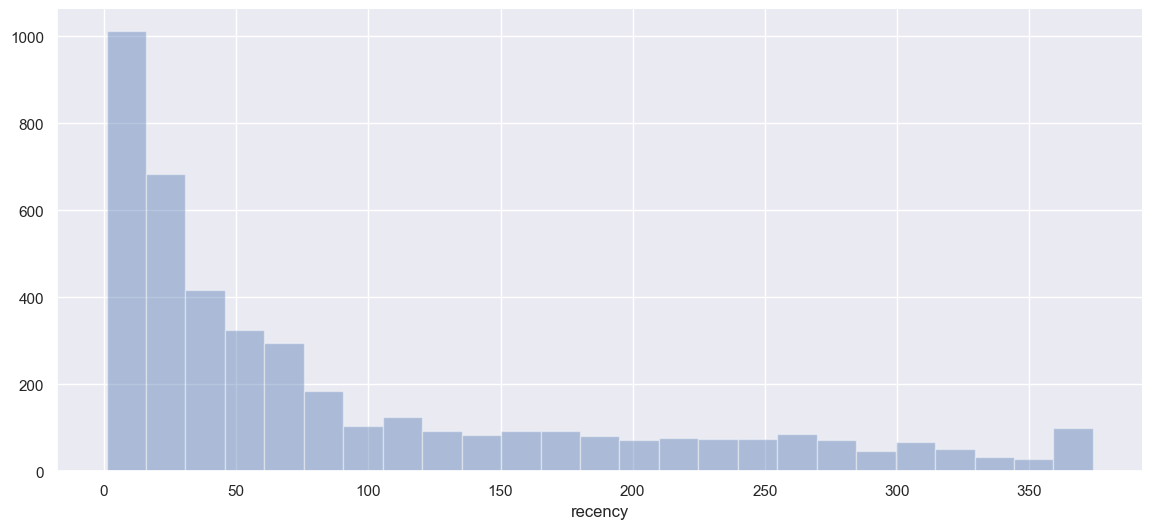

In [33]:
sns.set(rc={'figure.figsize':(14,6)})
sns.distplot(rfm.recency, kde=False)
sns.despine()

In [76]:
print(rfm.recency.quantile(q=0.33))
print(rfm.recency.quantile(q=0.66))

24.0
87.0


###### Split Recency into three periods. The latter will lie beyond the mark of 292 days, as the quantile = 0.66 showed us, the border of the first will end a little earlier than the quantile of 0.33, judging by the graph, this is somewhere between 90-100 days, let's take 90, we will consider 3 months as the maximum age for our young users.

In [39]:
def R(recency):
    if recency <=90:
        return 3
    elif recency > 292:
        return 1
    else:
        return 2

rfm['r'] = rfm.recency.apply(R)

In [74]:
rfm.frequency.value_counts().to_list()[0] / sum(rfm.frequency.value_counts().to_list()[:])

0.018069533394327538

###### Let's do the same with Frequency - split into three groups.

###### 1 - 1 purchase
###### 2 - 2 purchases
###### 3 - 3 or more purchases

In [77]:
def F(frequency):
    if frequency == 1:
        return 1
    elif frequency == 2:
        return 2
    else:
        return 3

rfm['f'] = rfm.frequency.apply(F)

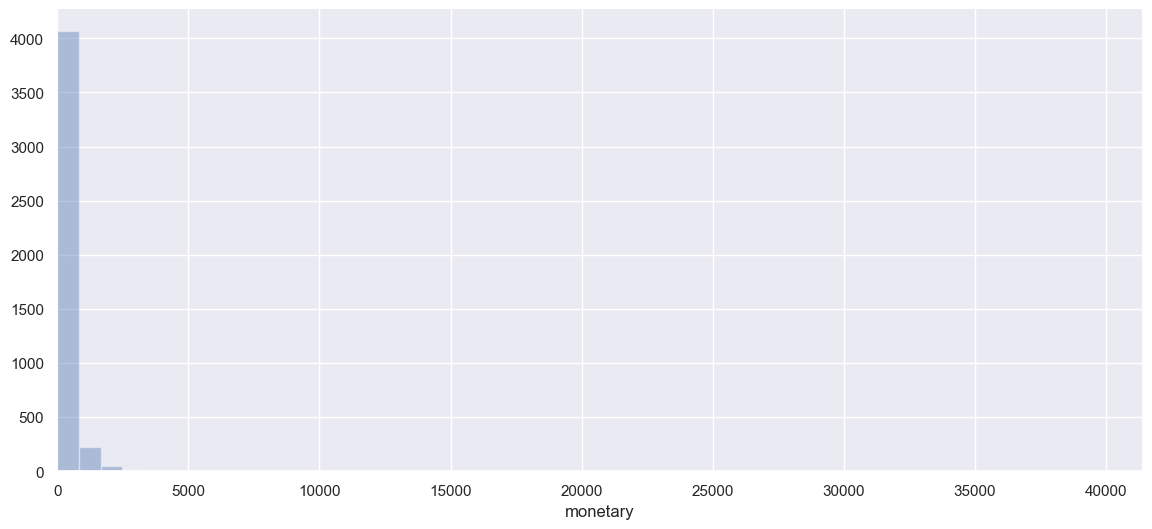

In [84]:
sns.distplot(rfm.monetary, kde=False)
plt.xlim(0, rfm.monetary.max())
sns.despine()


In [85]:
rfm.monetary.describe()

count     4372.000000
mean       322.008226
std       1284.783098
min          0.000000
25%         52.865000
50%        130.095000
75%        302.332500
max      41376.330000
Name: monetary, dtype: float64

###### Let:

###### 1 - spend up to $100

###### 2 - from 100 to thousands

###### 3 - all others

In [86]:
def M(monetary):
    if monetary <= 100:
        return 1
    elif monetary > 1000:
        return 3
    else:
        return 2

rfm['m'] = rfm.monetary.apply(M)

In [87]:
rfm['RFM'] = rfm['r'].astype(str) + rfm['f'].astype(str) + rfm['m'].astype(str)
rfm.head()

,CustomerID,recency,frequency,monetary,r,f,m,RFM
0,12346.0,326,2,2.08,1,2,1,121
1,12347.0,2,182,481.21,3,3,2,332
2,12348.0,75,31,178.71,3,3,2,332
3,12349.0,19,73,605.10,3,3,2,332
4,12350.0,310,17,65.30,1,3,1,131


###### The resulting table for each customer, with his relation to a specific RFM cluster, is ready.
###### Next, we divide into groups with average values for each metric:

In [95]:
rfm_grouped = rfm.groupby('RFM').agg({'recency': 'mean', 'frequency': 'mean', 'monetary': 'mean'}).round(1)
rfm_grouped.value_counts().count()

np.int64(23)

In [97]:
rfm_graph = rfm.groupby('RFM', as_index=False) \
               .agg({'CustomerID': 'count'}) \
               .rename(columns={'CustomerID': 'num_of_customers'})
rfm_graph.head()

,RFM,num_of_customers
0,111,26
1,112,2
2,113,1
3,121,11
4,131,183


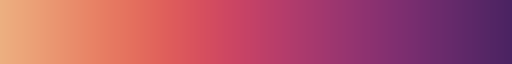

In [96]:
sns.color_palette("flare", as_cmap=True)

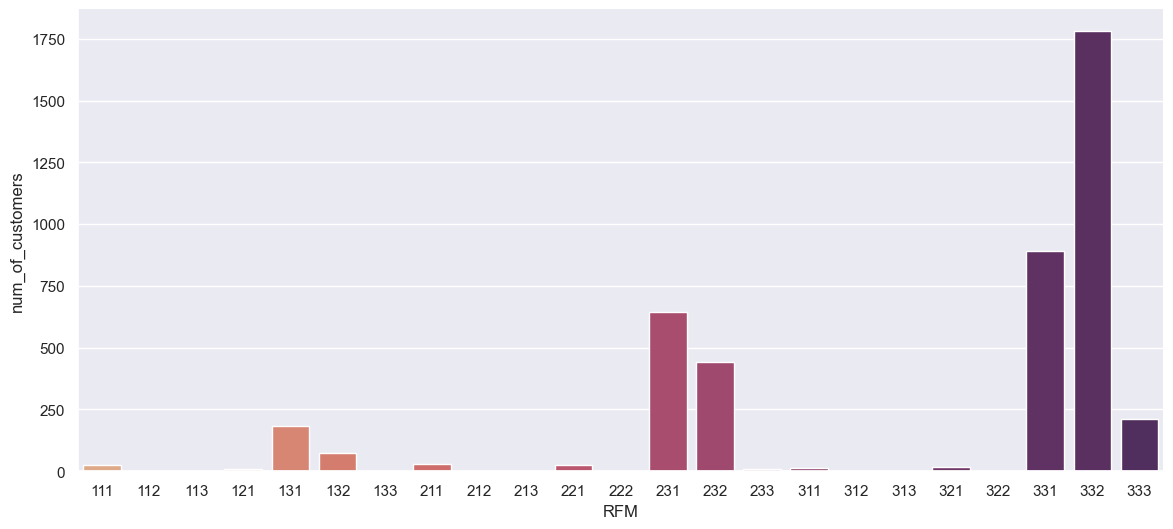

In [98]:
sns.barplot(data=rfm_graph, x='RFM', y='num_of_customers', palette="flare")
sns.despine()

###### The barplot shows the number of clients belonging to a particular cluster.